In [1]:
from tsai.all import *
from sktime.datasets import load_UCR_UEA_dataset

## Описание датасета
Датасет взят [отсюда](https://www.timeseriesclassification.com/description.php?Dataset=Computers)

Признак - потребление электроэнергии.  
Данные содержат показания 251 домохозяйства, взятые с двухминутными интервалами в течение месяца. Длина каждой серии - 720 (24 часа показаний, снятых каждые 2 минуты).  
Классы: настольный компьютер (1 класс) и ноутбук (2 класс).  


In [22]:
X, y, splits = get_classification_data('Computers', split_data=False)

Для начала пробуем пример с ноутбука с лекций

In [23]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
 
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])

In [26]:
archs = [
         (RNNPlus, {} ),
         (LSTMPlus,{} ),
         (GRUPlus, {} ),   
         (RNNPlus, {} ),
         (RNNPlus, {}),  
         (LSTM,    {}), 
         (RNN,     {} ), 
         (LSTM,    {} ),
         (GRU,     {} ),   
         (ResNet, {}), 
         (xresnet1d34, {}), 
         (xresnet1d50_deeper, {}), 
         (InceptionTime, {}), 
         (XceptionTime,  {}), 
         (TCN, {}),   
         (LSTM_FCN, {}), 
         (TST, {}),
         (FCN, {}),   
        ]

In [27]:
from IPython.display import clear_output



results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
   
    model = create_model(arch, dls=dls, **k)
    
    print(model.__class__.__name__)
    
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478466,0.434592,0.613436,0.664,40
1,RNNPlus,{},10502,0.680126,0.680717,0.624,7
2,RNNPlus,{},10502,0.694214,0.693506,0.592,7
3,LSTMPlus,{},41402,0.688459,0.696782,0.548,11
4,LSTM,{},41402,0.690775,0.697928,0.516,11
5,GRUPlus,{},31102,0.689916,0.698300,0.512,34
6,GRU,{},31102,0.689554,0.697268,0.492,34
7,LSTM,{},41402,0.688117,0.698076,0.488,10
8,RNN,{},10502,0.704201,0.699791,0.484,6
9,RNNPlus,{},10502,0.695219,0.694712,0.460,7


TypeError: Conv1d.__init__() got an unexpected keyword argument 'seq_len'

In [29]:
arch = RNNPlus
k = {'n_layers': 4, 'bidirectional': True}
model = create_model(arch, dls=dls, **k)

In [30]:
model = build_ts_model(RNNPlus, arch_config=k, dls=dls)

SuggestedLRs(valley=4.365158383734524e-05)

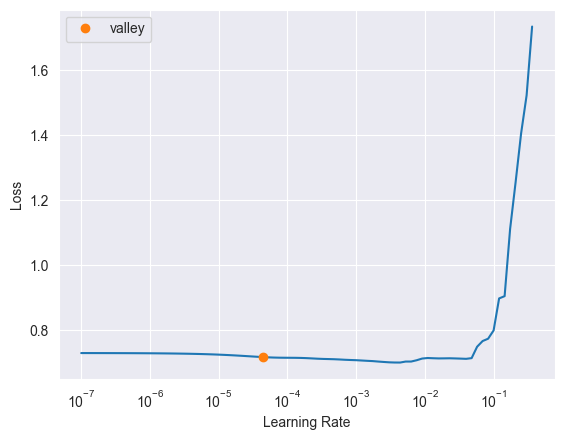

In [31]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.728874,0.724562,0.500000,00:04
1,0.728108,0.722900,0.500000,00:03
2,0.727303,0.720891,0.500000,00:03
3,0.726398,0.718352,0.500000,00:03
4,0.725342,0.715180,0.500000,00:03
5,0.724099,0.711373,0.500000,00:03
6,0.722652,0.707041,0.500000,00:03
7,0.721008,0.702415,0.500000,00:03
8,0.719194,0.697841,0.500000,00:03
9,0.717265,0.693761,0.500000,00:03


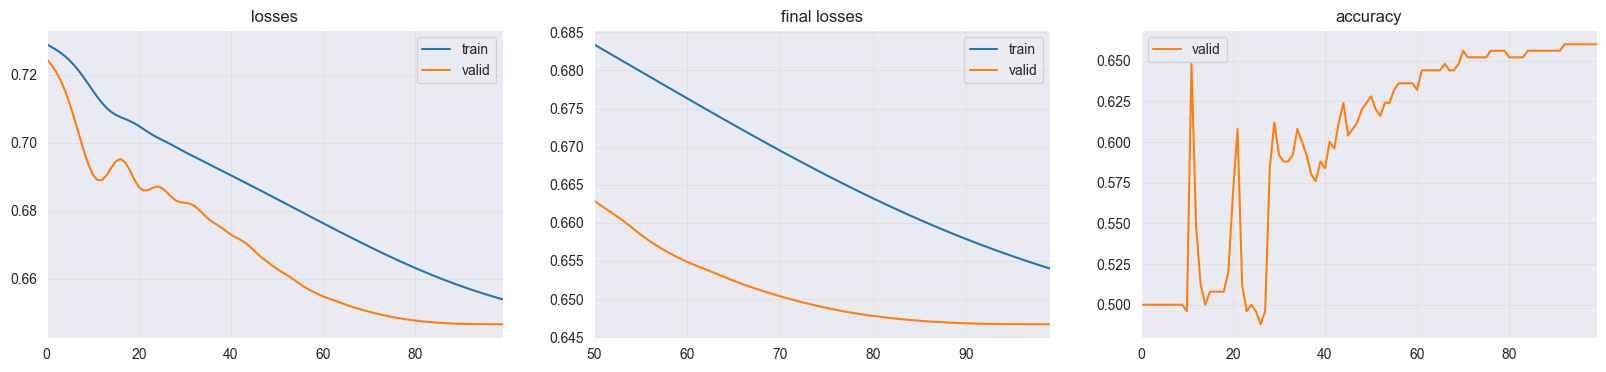

In [33]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.00009, cbs=ShowGraph())


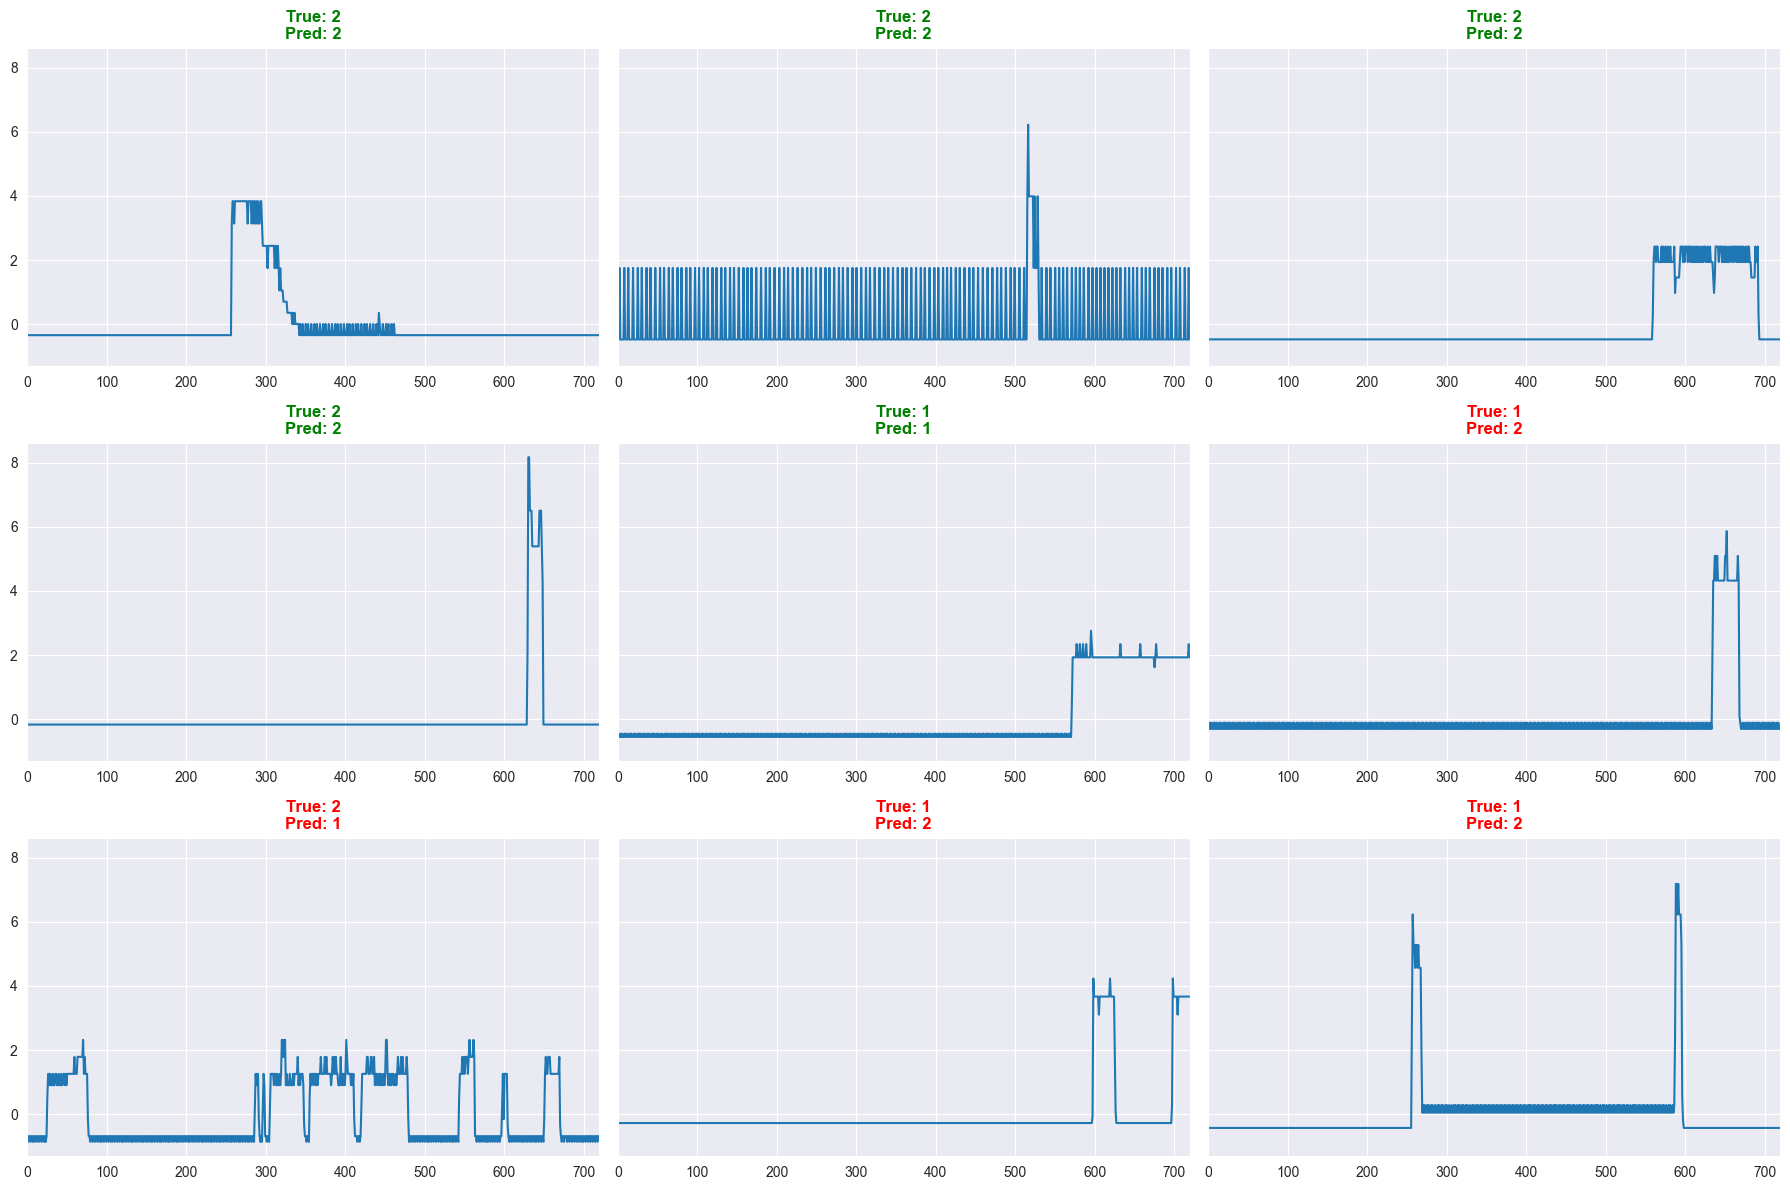

In [34]:
learn.show_results(sharey=True)

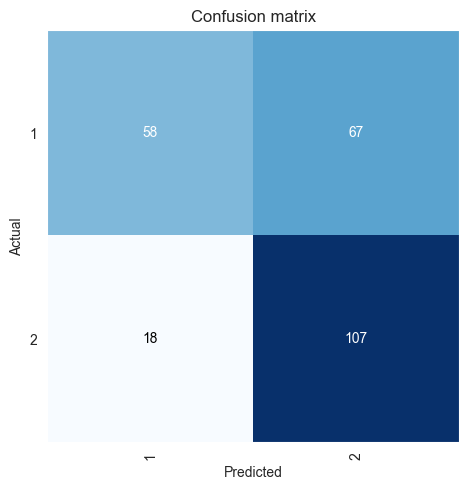

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [39]:
interp.print_classification_report()

              precision    recall  f1-score   support

           1       0.76      0.46      0.58       125
           2       0.61      0.86      0.72       125

    accuracy                           0.66       250
   macro avg       0.69      0.66      0.65       250
weighted avg       0.69      0.66      0.65       250



Судя по матрице и метрикам 1 класс довольно плохо предсказывается, попробуем взять пример классификатора из офф документации

epoch,train_loss,valid_loss,accuracy,time


epoch,train_loss,valid_loss,accuracy,time
0,0.744105,0.699097,0.500000,00:03
1,0.725786,0.699859,0.500000,00:03
2,0.706560,0.701033,0.500000,00:03
3,0.692540,0.701593,0.500000,00:03
4,0.676777,0.700885,0.500000,00:03
5,0.664409,0.697978,0.500000,00:03
6,0.650735,0.691419,0.512000,00:03
7,0.639179,0.679776,0.572000,00:03
8,0.628530,0.661796,0.656000,00:03
9,0.617752,0.642354,0.672000,00:03


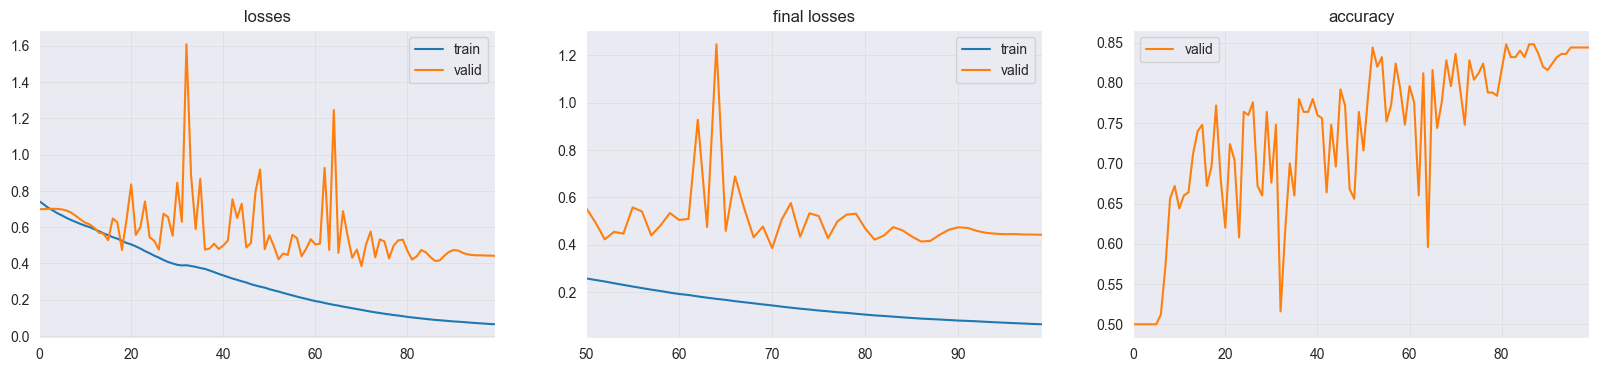

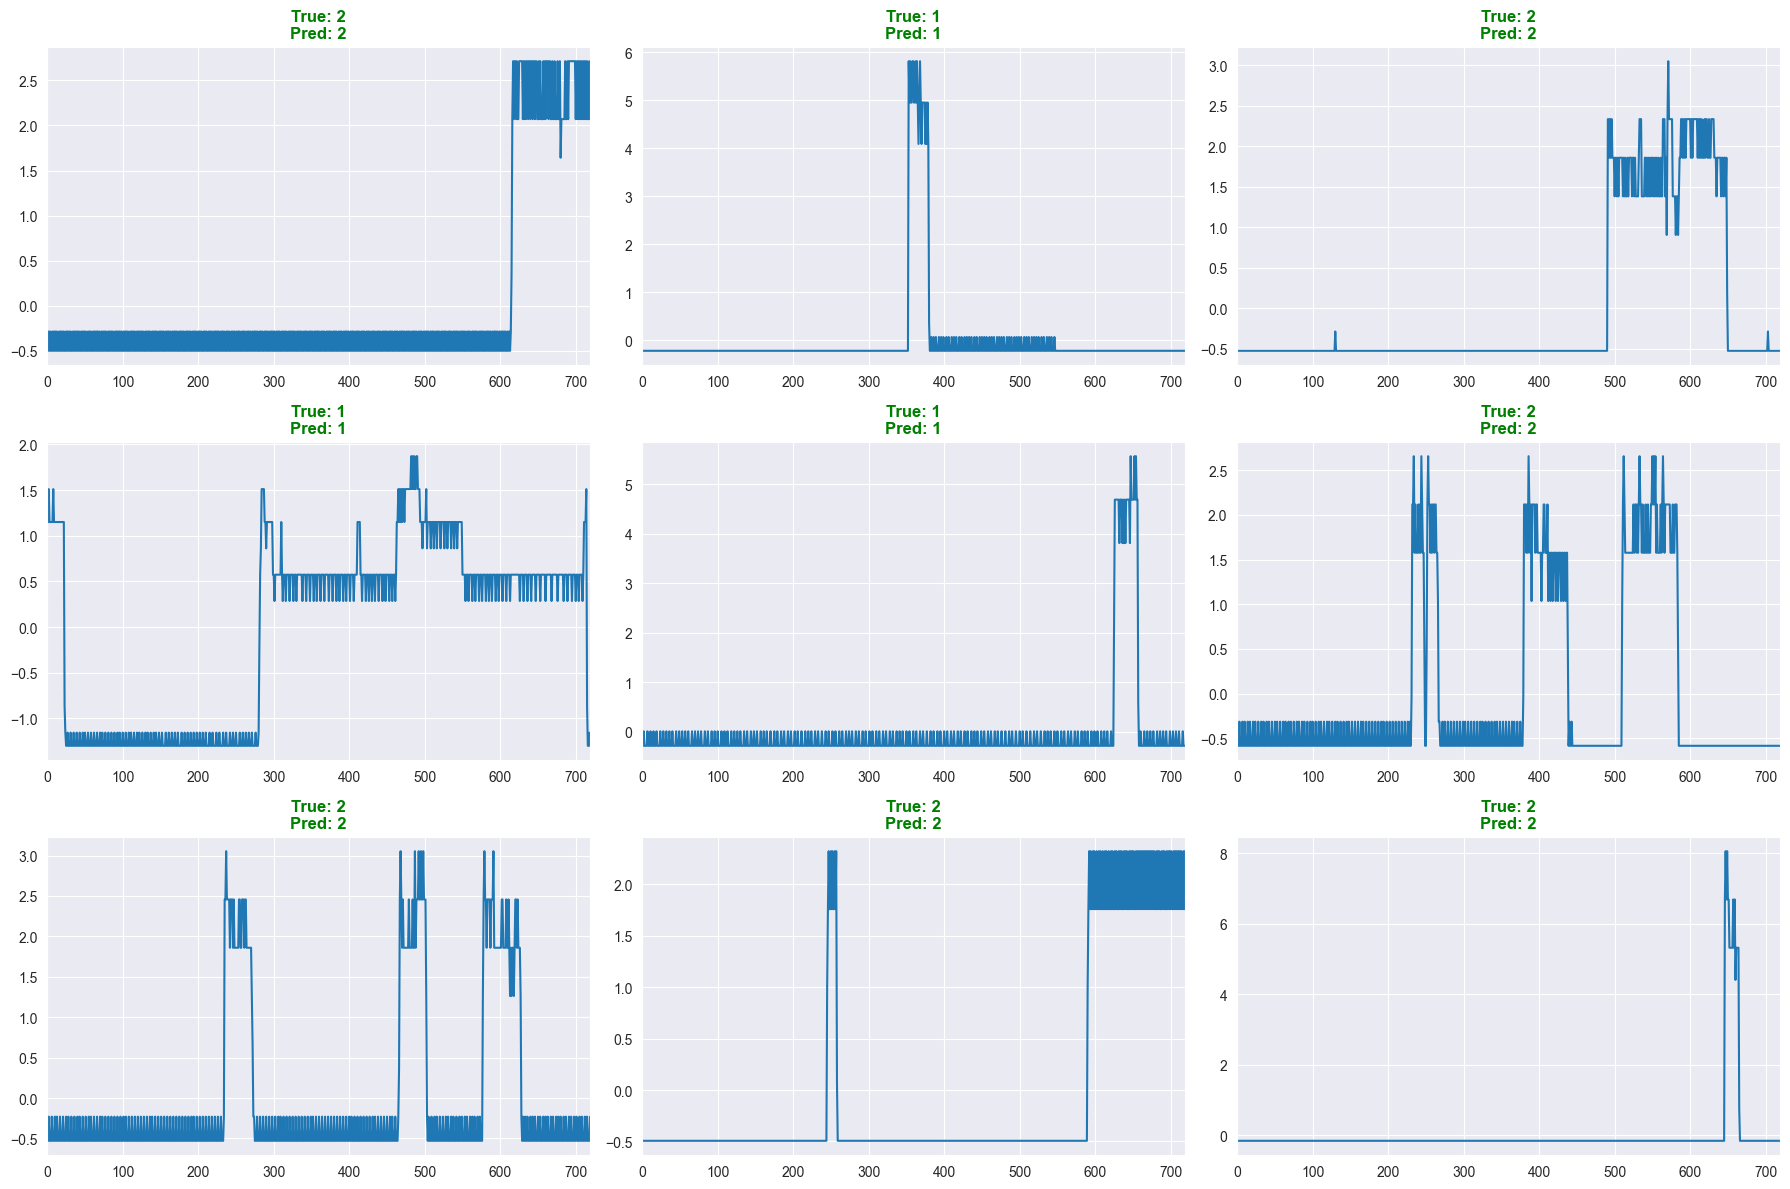

In [32]:
tfms = [None, TSClassification()]
batch_tfms = TSStandardize()
clf = TSClassifier(X, y, splits=splits, path='models', arch="InceptionTimePlus", tfms=tfms, batch_tfms=batch_tfms, metrics=accuracy, cbs=ShowGraph())
clf.fit_one_cycle(100, 3e-4)
clf.show_results()

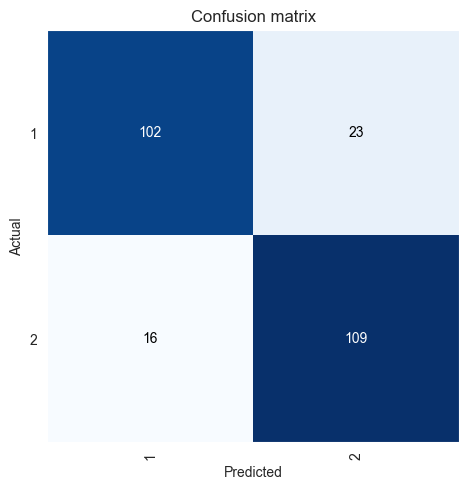

In [37]:
interp_two = ClassificationInterpretation.from_learner(clf)
interp_two.plot_confusion_matrix()

In [38]:
interp_two.print_classification_report()

              precision    recall  f1-score   support

           1       0.86      0.82      0.84       125
           2       0.83      0.87      0.85       125

    accuracy                           0.84       250
   macro avg       0.85      0.84      0.84       250
weighted avg       0.85      0.84      0.84       250



Тут уже получилось гораздо лучше, 1 и 2 класс довольно хорошо предсказываются